In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

from option_pricing.utilities import *
from option_pricing.options_pricing import *
from forex_smile.fx_smile import ForexSmile
from delta_hedging.delta_hedging import DeltaHedging
from price_aggregation.price_aggregation import PriceAggregation

Hedge in future

In [70]:
S0=105.910000
T=0.978000
K=97.770000
r=0.004000
q=0.093000
sigma=0.204300
T_fut=0.340000
grecs = CallVanillaOption.black_schole_grecs(0, sigma, r, q, S0, T, K)
delta_call = grecs[0]
delta_future = delta_call*np.exp(-(r-q)*T_fut)
delta_future

0.49532719160224126

Contract with payoff $S_T(S_T-K)_+$

In [73]:
S0=10.450000
T=0.572000
K=10.070000
r=0
q=0
sigma=0.104400
d1=(1/(sigma*np.sqrt(T)))*np.log((S0*np.exp((r-q)*(T)))/K)+(1/2)*sigma*np.sqrt(T)
d2=d1 + sigma*np.sqrt(T)
call=S0**2*np.exp((r-2*q+sigma**2)*T)*norm.cdf(d2)-K*(S0*np.exp(-q*(T)))*norm.cdf(d1)
call

6.210197391587528

Strike to have a delta hedge

In [4]:
def strike_function(K, delta_1, delta_2, a, b, S2, S1, T, sigma, r=0, q=0):
    grecs_3 = CallVanillaOption.black_schole_grecs(0, sigma, r, q, S2/S1, T, K)
    call_price = CallVanillaOption.black_schole_price(0, sigma, r, q, S2/S1, T, K)
    delta_3 = grecs_3[0]
    value = a*delta_1 + b*(delta_2/delta_3)*call_price - b*(S2/S1)*delta_2
    return value

def find_strike_for_delta_hedging(delta_1, delta_2, a, b, S2, S1, T, sigma):
    K_values = np.linspace(0.95, 1.05, 1000)
    delta = [strike_function(K, delta_1, delta_2, a, b, S2, S1, T, sigma) for K in K_values]
    return {'K': K_values, 'delta': delta}

def linear_interpolation(x, x0, x1, y0, y1):
        y= ((x1-x)*y0 + (x-x0)*y1)/(x1-x0)
        return y

0.9899999986273788

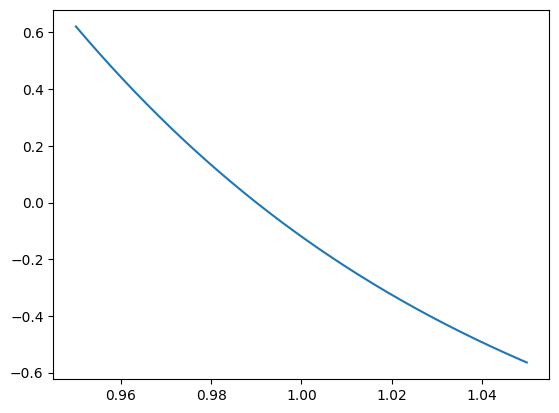

In [74]:
a=35.473073
b=44.910490
S1=95.690000
S2=95.180000
T=0.168000
K1=91.110000
K2=93.040000
r=0.073000
sigma1=0.105600
sigma2=0.117800
rho=0.080000
q=0
sigma = np.sqrt(sigma1**2+sigma2**2-2*rho*sigma1*sigma2)
grecs_1 = CallVanillaOption.black_schole_grecs(0, sigma1, r, q, S1, T, K1)
grecs_2 = CallVanillaOption.black_schole_grecs(0, sigma2, r, q, S2, T, K2)
delta_1 = grecs_1[0]
delta_2 = grecs_2[0]
result = find_strike_for_delta_hedging(delta_1, delta_2, a, b, S2, S1, T, sigma)
plt.plot(result['K'], result['delta'])
for i in range(1, len(result['delta'])):
    if result['delta'][i]*result['delta'][i-1]<=0:
        break
K = linear_interpolation(0, result['delta'][i],result['delta'][i-1], result['K'][i],result['K'][i-1])
K

PnL

In [75]:
def pnl(r, t, implied_volatility, spot_volatility, spot, K, T, q=0):
    grecs = PutVanillaOption.black_schole_grecs(0, implied_volatility, r, q, spot, T-t, K)
    gamma = grecs[1]
    return np.exp(-r*t)*0.5*spot**2*gamma*(implied_volatility**2-spot_volatility**2)

In [76]:
data  = pd.read_csv("data/pnl_quizz_libre_4.csv", sep=';')
columns = data.columns
for col in columns:
    if col.startswith("Unnamed"):
        del data[col]
data = data.rename(columns={ 'Date' : 'date', 'Spot' : 'spot' })
data

,date,spot
0,0.000,93.65
1,0.004,92.30
2,0.008,90.39
3,0.012,89.34
4,0.016,89.69
...,...,...
216,0.864,79.02
217,0.868,81.32
218,0.872,82.12
219,0.876,82.36


In [77]:
K=96.25
implied_volatility = 26.66/100
spot_volatility = 21.08/100
T=0.880
r=4.10/100
pnl_list = []
for i in range(len(data)):
    pnl_list.append(pnl(r, data['date'][i], implied_volatility, spot_volatility, data['spot'][i], K, T))
pnl_list

c:\Users\akibo\OneDrive\Documents\Master\StochasticModelling\PricingLibrary\pricing_library\option_pricing\options_pricing.py:155: RuntimeWarning: divide by zero encountered in scalar divide
  d1=(1/(sigma*np.sqrt(T-t)))*np.log((St*np.exp((r-q)*(T-t)))/K)+(1/2)*sigma*np.sqrt(T-t)
c:\Users\akibo\OneDrive\Documents\Master\StochasticModelling\PricingLibrary\pricing_library\option_pricing\options_pricing.py:158: RuntimeWarning: invalid value encountered in scalar divide
  gamma=(np.exp(-q*(T-t))*norm.pdf(d1))/((St*np.exp(-q*(T-t)))*sigma*np.sqrt(T-t))
c:\Users\akibo\OneDrive\Documents\Master\StochasticModelling\PricingLibrary\pricing_library\option_pricing\options_pricing.py:160: RuntimeWarning: invalid value encountered in scalar divide
  theta=(St*np.exp(-q*(T-t)))*norm.pdf(d1)*sigma/(2*np.sqrt(T-t))+r*np.exp(-r*(T-t))*K*norm.cdf(-d0)


[1.9645217274875515,
 1.9552861198331544,
 1.928422729319514,
 1.9093257001373336,
 1.9216240395629178,
 1.9072720837854709,
 1.9123156572926328,
 1.8586970856330587,
 1.893175984366638,
 1.9355723411099248,
 1.9522769886757934,
 1.9186943907832237,
 1.9374205053826299,
 1.8919673027465005,
 1.9774929195236044,
 1.9949078824858302,
 1.972891904939206,
 1.9491156893649566,
 1.9518782536021986,
 1.9279374950635193,
 1.8667375630177554,
 1.8882739892629998,
 1.942359880650963,
 1.956417461938412,
 1.964380658989073,
 1.8931955945652439,
 1.7622595614676835,
 1.8244038271775462,
 1.847741893239533,
 1.7960402775974624,
 1.835316512901625,
 1.8831415157825584,
 1.905434607904742,
 1.8962276266554632,
 1.9639788850438533,
 1.9276665766234724,
 1.8829094153296642,
 1.8085387616703372,
 1.806458246326133,
 1.8686374417542861,
 1.8732224915741056,
 1.8267330087045182,
 1.7211518103144312,
 1.7149947075308618,
 1.8061069510106544,
 1.7007927983436264,
 1.5811178443171212,
 1.6370163506319364,
 1

In [78]:
pnl_array  = np.array(pnl_list)
integral_value = np.sum(0.004*pnl_array[:-1])
pnl_value = integral_value*np.exp(r*T)
pnl_value

0.8031050321608274

Garman-Kolhagen Model (r = r_domestic - r_foreign)

In [79]:
X0=1.034300
T=0.255000
K=1.014700
r_euro=0.092800
r_dollar=0.047100
r = r_euro-r_dollar
sigma=0.076200
q=0
d1=(1/(sigma*np.sqrt(T)))*np.log((X0*np.exp((r-q)*(T)))/K)+(1/2)*sigma*np.sqrt(T)
d0=d1-(sigma*np.sqrt(T))
call=(X0*np.exp(-(r_dollar+q)*(T)))*norm.cdf(d1)-np.exp(-r_euro*(T))*K*norm.cdf(d0)
call

0.03563567278780322

Supply liquidity percentage

In [81]:
x=133.090000
y=567.850000
delta_x=74.100000
delta_y=0
L_before = x*y
L_after = (x+delta_x)*(y+delta_y)
delta_L = L_after - L_before
supply_percentage = delta_L/L_after
supply_percentage

0.3576427433756455

Number of token x

In [82]:
L=438.640848
p=9.921226
x = L / np.sqrt(p)
x

139.26000329248853

Liquidity in the pool after a transaction with fees  when delta_x is given

In [83]:
def k(d, phi):
    k_expression= (((2-phi)*(1-d))/(2))-1
    return k_expression

In [84]:
x=559.030000
y=863.450000
delta_x=110.620000
phi=0.003
d=-1 #y a été retiré
coeff_delta_y = (k(d, phi)*y)/(k(-d, phi)*(x+k(d, phi)*delta_x))
delta_y = -coeff_delta_y*delta_x
L = np.sqrt((x-d*delta_x)*(y+d*delta_y))
L

694.934372521506

Liquidity in the pool after a transaction with fees  when delta_y is given

In [ ]:
x=145.350000
y=463.870000
delta_y=30.410000
phi=0.003
d=-1 #y a été retiré
coeff_delta_x = (k(-d, phi)*x)/(k(d, phi)*(y+k(-d, phi)*delta_y))
delta_x = -coeff_delta_x*delta_y
L = np.sqrt((x-d*delta_x)*(y+d*delta_y))
L

259.68597320810983

Uniswap v3 number of tokens X

In [87]:
#Vérifier si p est dans la plage de prix
L=49132.000000
pl=85.180000
pu=91.770000
p=87.870000
x= L/np.sqrt(p) - L/np.sqrt(pu)
x

112.58160648296871

Uniswap v3 delta liquidity  when delta_y is given

In [88]:
#Vérifier si p est dans la plage de prix
L=10637.000000
pl=40.310000
pu=41.880000
p=40.810000
delta_y=38.080000
delta_L = delta_y/(np.sqrt(p)-np.sqrt(pl))
delta_L

970.071714951951

Uniswap v3 delta liquidity  when delta_x is given

In [91]:
#Vérifier si p est dans la plage de prix
L=86788.000000
pl=9.670000
pu=10.450000
p=10.160000
delta_x=65.630000
delta_L = delta_x/((1/np.sqrt(p))-(1/np.sqrt(pu)))
delta_L

14971.063426966037